# Counterfeit detection

The task in this assignment is to detect the  counterfeit banknotes. The data set is based on [banknote authentication Data Set ](https://archive.ics.uci.edu/ml/datasets/banknote+authentication#) from UCI Machine Learning repository.  You have already used this set but this time I have removed  the first column. The set  `banknote_authentication.csv` can be found in the `data`  directory.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st

In [2]:
data = pd.read_csv('data/banknote_authentication.csv', header=None)

In [3]:
data = pd.read_csv('data/banknote_authentication.csv' )

In [4]:
data.head()

,a1,a2,a3,counterfeit
0,12.3784,0.70403,-7.58360,0
1,8.1881,-3.13380,-2.52760,0
2,-10.8679,9.49260,-1.41160,1
3,-8.7903,7.97350,-0.45475,1
4,-5.5167,10.93900,-0.40820,1


## Problem 

### A.

Perform the Quadratic Discriminant Analysis on this set. Calculate the confusion matrix, AUC score and plot the ROC curve. 

Training Confusion Matrix:
 [[0.81472684 0.18527316]
 [0.17630058 0.82369942]]
Testing Confusion Matrix:
 [[0.80851064 0.19148936]
 [0.1971831  0.8028169 ]]
Training AUC Score: 0.897059025441764
Test AUC Score: 0.8651108780341624


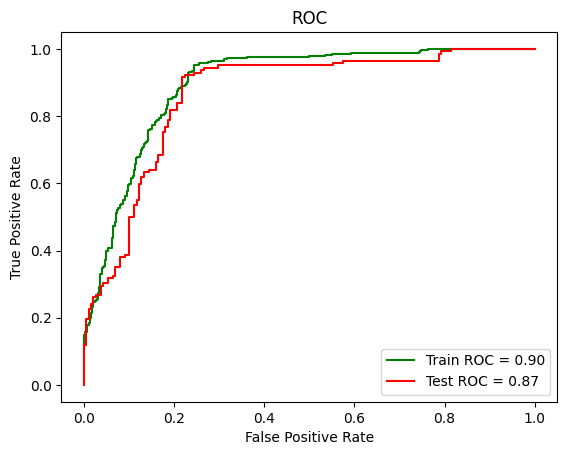

In [5]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, f1_score
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.mixture import GaussianMixture
from sklearn.naive_bayes import GaussianNB
from scipy.stats import multivariate_normal

data = pd.read_csv('data/banknote_authentication.csv')

X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train, y_train)

y_train_pred = qda.predict(X_train)
y_train_pred_proba = qda.predict_proba(X_train)[:, 1]

y_test_pred = qda.predict(X_test)
y_test_pred_proba = qda.predict_proba(X_test)[:, 1]

train_conf_matrix = confusion_matrix(y_train, y_train_pred, normalize='true')
print("Training Confusion Matrix:\n", train_conf_matrix)

test_conf_matrix = confusion_matrix(y_test, y_test_pred, normalize='true')
print("Testing Confusion Matrix:\n", test_conf_matrix)

train_auc_score = roc_auc_score(y_train, y_train_pred_proba)
print("Training AUC Score:", train_auc_score)

test_auc_score = roc_auc_score(y_test, y_test_pred_proba)
print("Test AUC Score:", test_auc_score)

train_fpr, train_tpr, _ = roc_curve(y_train, y_train_pred_proba)
plt.plot(train_fpr, train_tpr, label='Train ROC = %0.2f' % train_auc_score, color = 'green')

test_fpr, test_tpr, _ = roc_curve(y_test, y_test_pred_proba)
plt.plot(test_fpr, test_tpr, label='Test ROC = %0.2f' % test_auc_score, color = 'red')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

### B.

Perform Gaussian Mixture Discriminant Analysis on this set as described in the `gaussian_mixture_model_EM_algorithm` notebook. Use two components for positives and two components for negatives. Calculate the confusion matrix, AUC score and plot the ROC curve. 

C:\Users\ranke\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\ranke\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


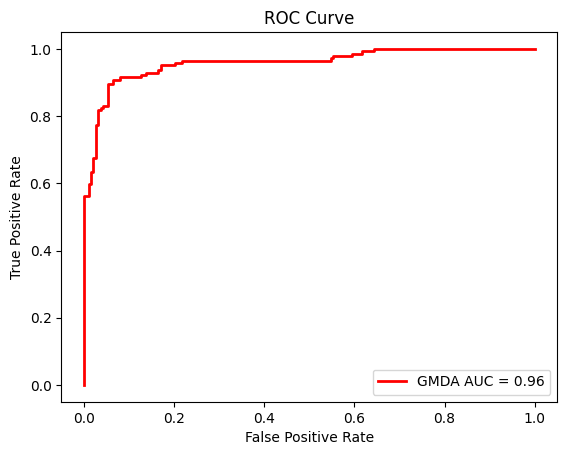

AUC Score: 0.9595819598441714
Confusion Matrix:
[[0.95744681 0.04255319]
 [0.16901408 0.83098592]]


In [6]:
X_pos_train = X_train[y_train == 1]
X_neg_train = X_train[y_train == 0]

gmm_pos = GaussianMixture(n_components=2, max_iter=100, tol=0.0001)
gmm_neg = GaussianMixture(n_components=2, max_iter=100, tol=0.0001)

gmm_pos.fit(X_pos_train)
gmm_neg.fit(X_neg_train)

pi_pos = len(X_pos_train) / len(X_train)
pi_neg = len(X_neg_train) / len(X_train)

def make_predict_proba(gmm_pos, gmm_neg, pi_pos, pi_neg):
    def predict_proba(x):
        pdf_pos = np.exp(gmm_pos.score_samples(x))
        pdf_neg = np.exp(gmm_neg.score_samples(x))
        p_pos = pi_pos * pdf_pos / (pi_pos * pdf_pos + pi_neg * pdf_neg)
        return p_pos
    return predict_proba

gmd_predict_proba = make_predict_proba(gmm_pos, gmm_neg, pi_pos, pi_neg)
gmd_proba = gmd_predict_proba(X_test)

cm = confusion_matrix(y_test, gmd_proba > 0.5, normalize='true')
auc_score = roc_auc_score(y_test, gmd_proba)
fpr, tpr, thresholds = roc_curve(y_test, gmd_proba)

plt.figure()
plt.plot(fpr, tpr, color='red', lw=2, label='GMDA AUC = %0.2f' % auc_score)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

print("AUC Score:", auc_score)
print("Confusion Matrix:")
print(cm)

### C.

Use k-fold cross validation to find the optimal number of gaussian components for each class. Use the f1-score as the performance metric. As before calculate the confusion matrix, AUC score and plot the ROC curve for the best classifier. Assume that maximal number of components in each class is 12. Remember that th enumber of clusters in each class does not have to be equal.  

__Hint__ use the `StratifiedKFold` function from scikit-learn library to generate folds. 

Best F1 Score: 0.95 with nc0 = 8, nc1 = 8


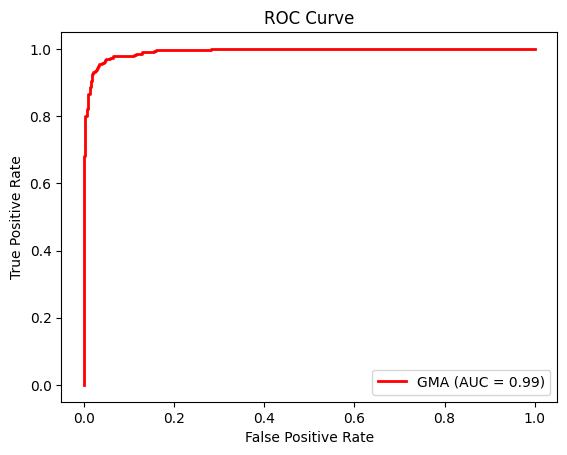

AUC Score: 0.9929574147352553
Confusion Matrix:
[[0.96715928 0.03284072]
 [0.05122951 0.94877049]]


In [7]:
def make_pdf(gmm):
    n_components = gmm.n_components
    dists = [multivariate_normal(gmm.means_[i], gmm.covariances_[i]) for i in range(n_components)]
    def pdf(x):
        p = 0.0
        for i in range(n_components):
            p += gmm.weights_[i] * dists[i].pdf(x)
        return p
    return pdf

def make_predict_proba(gmm0, gmm1, pi0, pi1):
    pdf0 = make_pdf(gmm0)
    pdf1 = make_pdf(gmm1)
    def p(x):
        p0 = pi0 * pdf0(x)
        p1 = pi1 * pdf1(x)
        return p1 / (p0 + p1)
    return p

def evaluate(nc0, nc1, X_train, y_train, X_valid, y_valid):
    hc0_cmp = GaussianMixture(n_components=nc0, max_iter=100, tol=1e-3, init_params='kmeans', random_state=42)
    hc1_cmp = GaussianMixture(n_components=nc1, max_iter=100, tol=1e-3, init_params='kmeans', random_state=42)
    hc0 = X_train[y_train == 0]
    hc1 = X_train[y_train == 1]

    try:
        hc0_cmp.fit(hc0)
        hc1_cmp.fit(hc1)
    except Exception as e:
        print(f"Error fitting GMM: {e}")
        return -1 

    pi0 = len(hc0) / len(X_train)
    pi1 = len(hc1) / len(X_train)

    gmda = make_predict_proba(hc0_cmp, hc1_cmp, pi0, pi1)
    proba = gmda(X_valid)
    return f1_score(y_valid, proba > 0.5)

max_components = 12
best_nc0 = None
best_nc1 = None
best_f1 = -1
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for nc0 in range(1, max_components + 1):
    for nc1 in range(1, max_components + 1):
        f1 = 0
        for train_index, valid_index in skf.split(X, y):
            X_train_fold, X_valid_fold = X[train_index], X[valid_index]
            y_train_fold, y_valid_fold = y[train_index], y[valid_index]
            f1 += evaluate(nc0, nc1, X_train_fold, y_train_fold, X_valid_fold, y_valid_fold)
        avg_f1 = f1 / skf.get_n_splits()
        if avg_f1 > best_f1:
            best_f1 = avg_f1
            best_nc0 = nc0
            best_nc1 = nc1
            
print(f"Best F1 Score: {best_f1:.2f} with nc0 = {best_nc0}, nc1 = {best_nc1}")
hc0_cmp_best = GaussianMixture(n_components=best_nc0, max_iter=100, tol=1e-3, init_params='kmeans', random_state=42)
hc1_cmp_best = GaussianMixture(n_components=best_nc1, max_iter=100, tol=1e-3, init_params='kmeans', random_state=42)
hc0_best = X[y == 0]
hc1_best = X[y == 1]

try:
    hc0_cmp_best.fit(hc0_best)
    hc1_cmp_best.fit(hc1_best)
except Exception as e:
    print(f"Error fitting best GMM: {e}")
    exit()

pi0_best = len(hc0_best) / len(X)
pi1_best = len(hc1_best) / len(X)

mgd_predict_proba = make_predict_proba(hc0_cmp_best, hc1_cmp_best, pi0_best, pi1_best)
mgd_proba = mgd_predict_proba(X)
cm = confusion_matrix(y, mgd_proba > 0.5, normalize='true')
auc_score = roc_auc_score(y, mgd_proba)
fpr, tpr, thresholds = roc_curve(y, mgd_proba)

plt.figure()
plt.plot(fpr, tpr, color='red', lw=2, label=f'GMA (AUC = {auc_score:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

print("AUC Score:", auc_score)
print("Confusion Matrix:")
print(cm)

## D.  

Assume that 1% of all the customers in your store try to pay with a counterfeit 100PLN bill. If you accept the counterfeit bill you loose 100PLN. If you reject a valid bill,  you may loose the purchase, you estimate this loss as 15PLN on average. For each of the three classifiers find the threshold that minimises your losses and calculates the minimum loss for each classifier. Show the optimal classifiers points on the ROC curves.

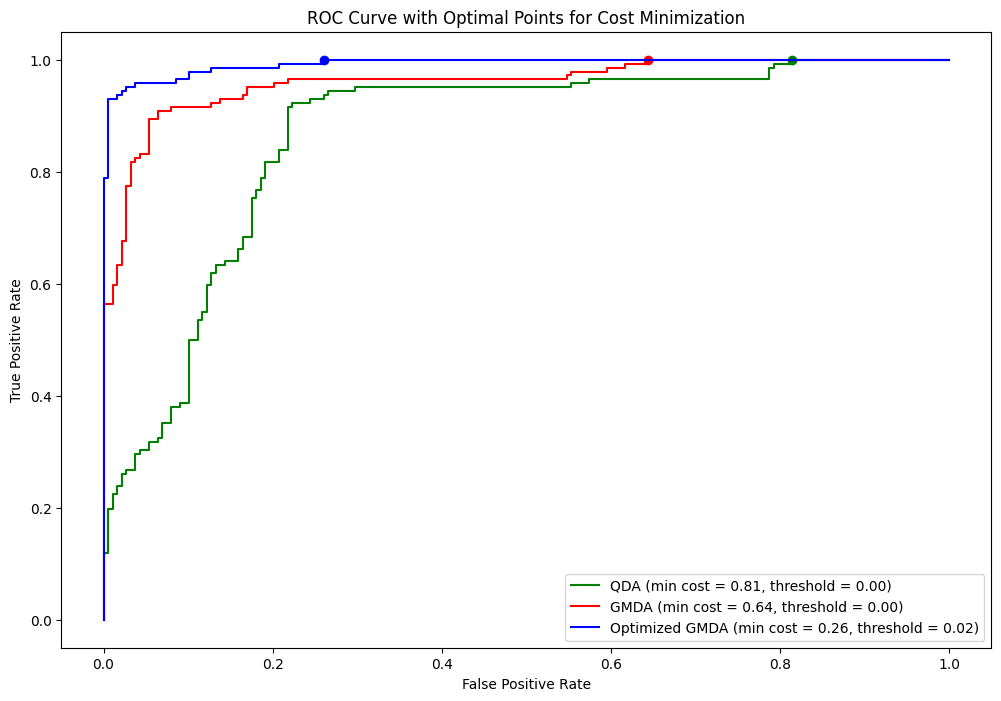

QDA Minimum Cost: 0.8138297872340425 Optimal Threshold: 0.0028188072974153315
GMDA Minimum Cost: 0.6436170212765957 Optimal Threshold: 0.00026519043552027403
Optimized GMDA Minimum Cost: 0.26063829787234044 Optimal Threshold: 0.019478696417099147


In [8]:
def calculate_cost(fp_rate, fn_rate, P=0.01, Cost_fp=100, Cost_fn=15):
    return P * fp_rate * Cost_fp + (1 - P) * fn_rate * Cost_fn
    
qda_proba = qda.predict_proba(X_test)[:, 1]
hc0_cmp_best = GaussianMixture(n_components=best_nc0, max_iter=100, tol=1e-3, init_params='kmeans', random_state=42)
hc1_cmp_best = GaussianMixture(n_components=best_nc1, max_iter=100, tol=1e-3, init_params='kmeans', random_state=42)
hc0_best = X[y == 0]
hc1_best = X[y == 1]

try:
    hc0_cmp_best.fit(hc0_best)
    hc1_cmp_best.fit(hc1_best)
except Exception as e:
    print(f"Error fitting best GMM: {e}")
    exit()

mgd_predict_proba = make_predict_proba(hc0_cmp_best, hc1_cmp_best, 0.5, 0.5)
mgd_proba = mgd_predict_proba(X_test)

def find_optimal_threshold(proba, y_true):
    fpr, tpr, thresholds = roc_curve(y_true, proba)
    costs = [calculate_cost(fp, 1 - tp) for fp, tp in zip(fpr, tpr)]
    min_cost_index = np.argmin(costs)
    min_cost = costs[min_cost_index]
    optimal_threshold = thresholds[min_cost_index]
    return min_cost, optimal_threshold, fpr, tpr, thresholds, min_cost_index

min_cost_qda, optimal_threshold_qda, fpr_qda, tpr_qda, thresholds_qda, min_cost_index_qda = find_optimal_threshold(qda_proba, y_test)

min_cost_gmm, optimal_threshold_gmm, fpr_gmm, tpr_gmm, thresholds_gmm, min_cost_index_gmm = find_optimal_threshold(gmd_proba, y_test)

min_cost_mgd, optimal_threshold_mgd, fpr_mgd, tpr_mgd, thresholds_mgd, min_cost_index_mgd = find_optimal_threshold(mgd_proba, y_test)

plt.figure(figsize=(12, 8))
plt.plot(fpr_qda, tpr_qda, label=f'QDA (min cost = {min_cost_qda:.2f}, threshold = {optimal_threshold_qda:.2f})', color='green')
plt.scatter(fpr_qda[min_cost_index_qda], tpr_qda[min_cost_index_qda], color='green')

plt.plot(fpr_gmm, tpr_gmm, label=f'GMDA (min cost = {min_cost_gmm:.2f}, threshold = {optimal_threshold_gmm:.2f})', color='red')
plt.scatter(fpr_gmm[min_cost_index_gmm], tpr_gmm[min_cost_index_gmm], color='red')

plt.plot(fpr_mgd, tpr_mgd, label=f'Optimized GMDA (min cost = {min_cost_mgd:.2f}, threshold = {optimal_threshold_mgd:.2f})', color='blue')
plt.scatter(fpr_mgd[min_cost_index_mgd], tpr_mgd[min_cost_index_mgd], color='blue')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve with Optimal Points for Cost Minimization')
plt.legend(loc="lower right")
plt.show()

print("QDA Minimum Cost:", min_cost_qda, "Optimal Threshold:", optimal_threshold_qda)
print("GMDA Minimum Cost:", min_cost_gmm, "Optimal Threshold:", optimal_threshold_gmm)
print("Optimized GMDA Minimum Cost:", min_cost_mgd, "Optimal Threshold:", optimal_threshold_mgd)